
# MAD — MFCC 2D‑CNN (GPU) — live curves

Trains a **2D‑CNN on MFCC(+Δ,+ΔΔ)** with **SpecAugment** using `training.csv`/`test.csv`.
Includes a **real‑time training curves** callback.

> **Install (optional)**: Uncomment and run next cell once.


In [ ]:

# !pip install tensorflow[and-cuda]==2.16.1 librosa==0.10.2.post1 soundfile scikit-learn matplotlib pandas numpy==1.26.4



## 1) GPU setup (memory growth + mixed precision)


In [31]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
print("TensorFlow:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {[g.name for g in gpus]}")
    for g in gpus:
        try:
            tf.config.experimental.set_memory_growth(g, True)
        except Exception as e:
            print("WARN memory_growth:", e)
    try:
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy('mixed_float16')
        MIXED_PRECISION = True
        print("Mixed precision: ENABLED")
    except Exception as e:
        print("WARN mixed precision:", e)
        MIXED_PRECISION = False
else:
    print("No GPU detected -> CPU mode.")
    MIXED_PRECISION = False

strategy = tf.distribute.MirroredStrategy() if len(gpus) > 1 else tf.distribute.get_strategy()
print("Using strategy:", type(strategy).__name__)


TensorFlow: 2.10.1
GPUs detected: ['/physical_device:GPU:0']
Mixed precision: ENABLED
Using strategy: _DefaultDistributionStrategy



## 2) Config


In [32]:

import json, numpy as np, pandas as pd
from pathlib import Path

BASE_DIR = r"C:\Users\Moham\Desktop\syrine\archive\MAD_dataset"
TRAIN_CSV = str(Path(BASE_DIR)/"training.csv")
TEST_CSV  = str(Path(BASE_DIR)/"test.csv")

SR = 16000
DURATION = 3.0
N_MFCC = 40
N_MELS = 64
N_FFT = 1024
HOP = 512
FMIN, FMAX = 20, None
USE_DELTAS = True
SPEC_AUG = True
FREQ_MASKS, FREQ_MASK_PCT = 2, 0.15
TIME_MASKS, TIME_MASK_PCT = 2, 0.10

BATCH_SIZE = 32
EPOCHS = 150
VAL_RATIO = 0.10
SEED = 42
LEARNING_RATE = 1e-3
EARLY_STOP_PATIENCE = 6

TARGET_SAMPLES = int(SR * DURATION)
TIME_STEPS = 1 + int(np.floor((TARGET_SAMPLES - N_FFT) / HOP))
N_CH = 3 if USE_DELTAS else 1
INPUT_SHAPE = (N_MFCC, TIME_STEPS, N_CH)

CKPT_DIR = str(Path(BASE_DIR)/"checkpoints_mfcc")
OUT_DIR = str(Path(BASE_DIR)/"models")
ANALYSIS_DIR = str(Path(BASE_DIR)/"analysis")
for d in (CKPT_DIR, OUT_DIR, ANALYSIS_DIR): Path(d).mkdir(parents=True, exist_ok=True)

CONFIG = {"SR":SR,"DURATION":DURATION,"N_MFCC":N_MFCC,"N_MELS":N_MELS,"N_FFT":N_FFT,
          "HOP":HOP,"FMIN":FMIN,"FMAX":FMAX,"USE_DELTAS":USE_DELTAS,
          "TIME_STEPS":TIME_STEPS,"N_CH":N_CH}
with open(Path(OUT_DIR)/"config.json","w") as f:
    json.dump(CONFIG, f, indent=2)


## 4.3 Preview 30 random training waveforms

Run the next cell to display **30 random `.wav`** files from a chosen split (train/val/test).  
Set `SHOW_SPECTRO = True` to see **mel‑spectrograms** instead of raw waveforms.

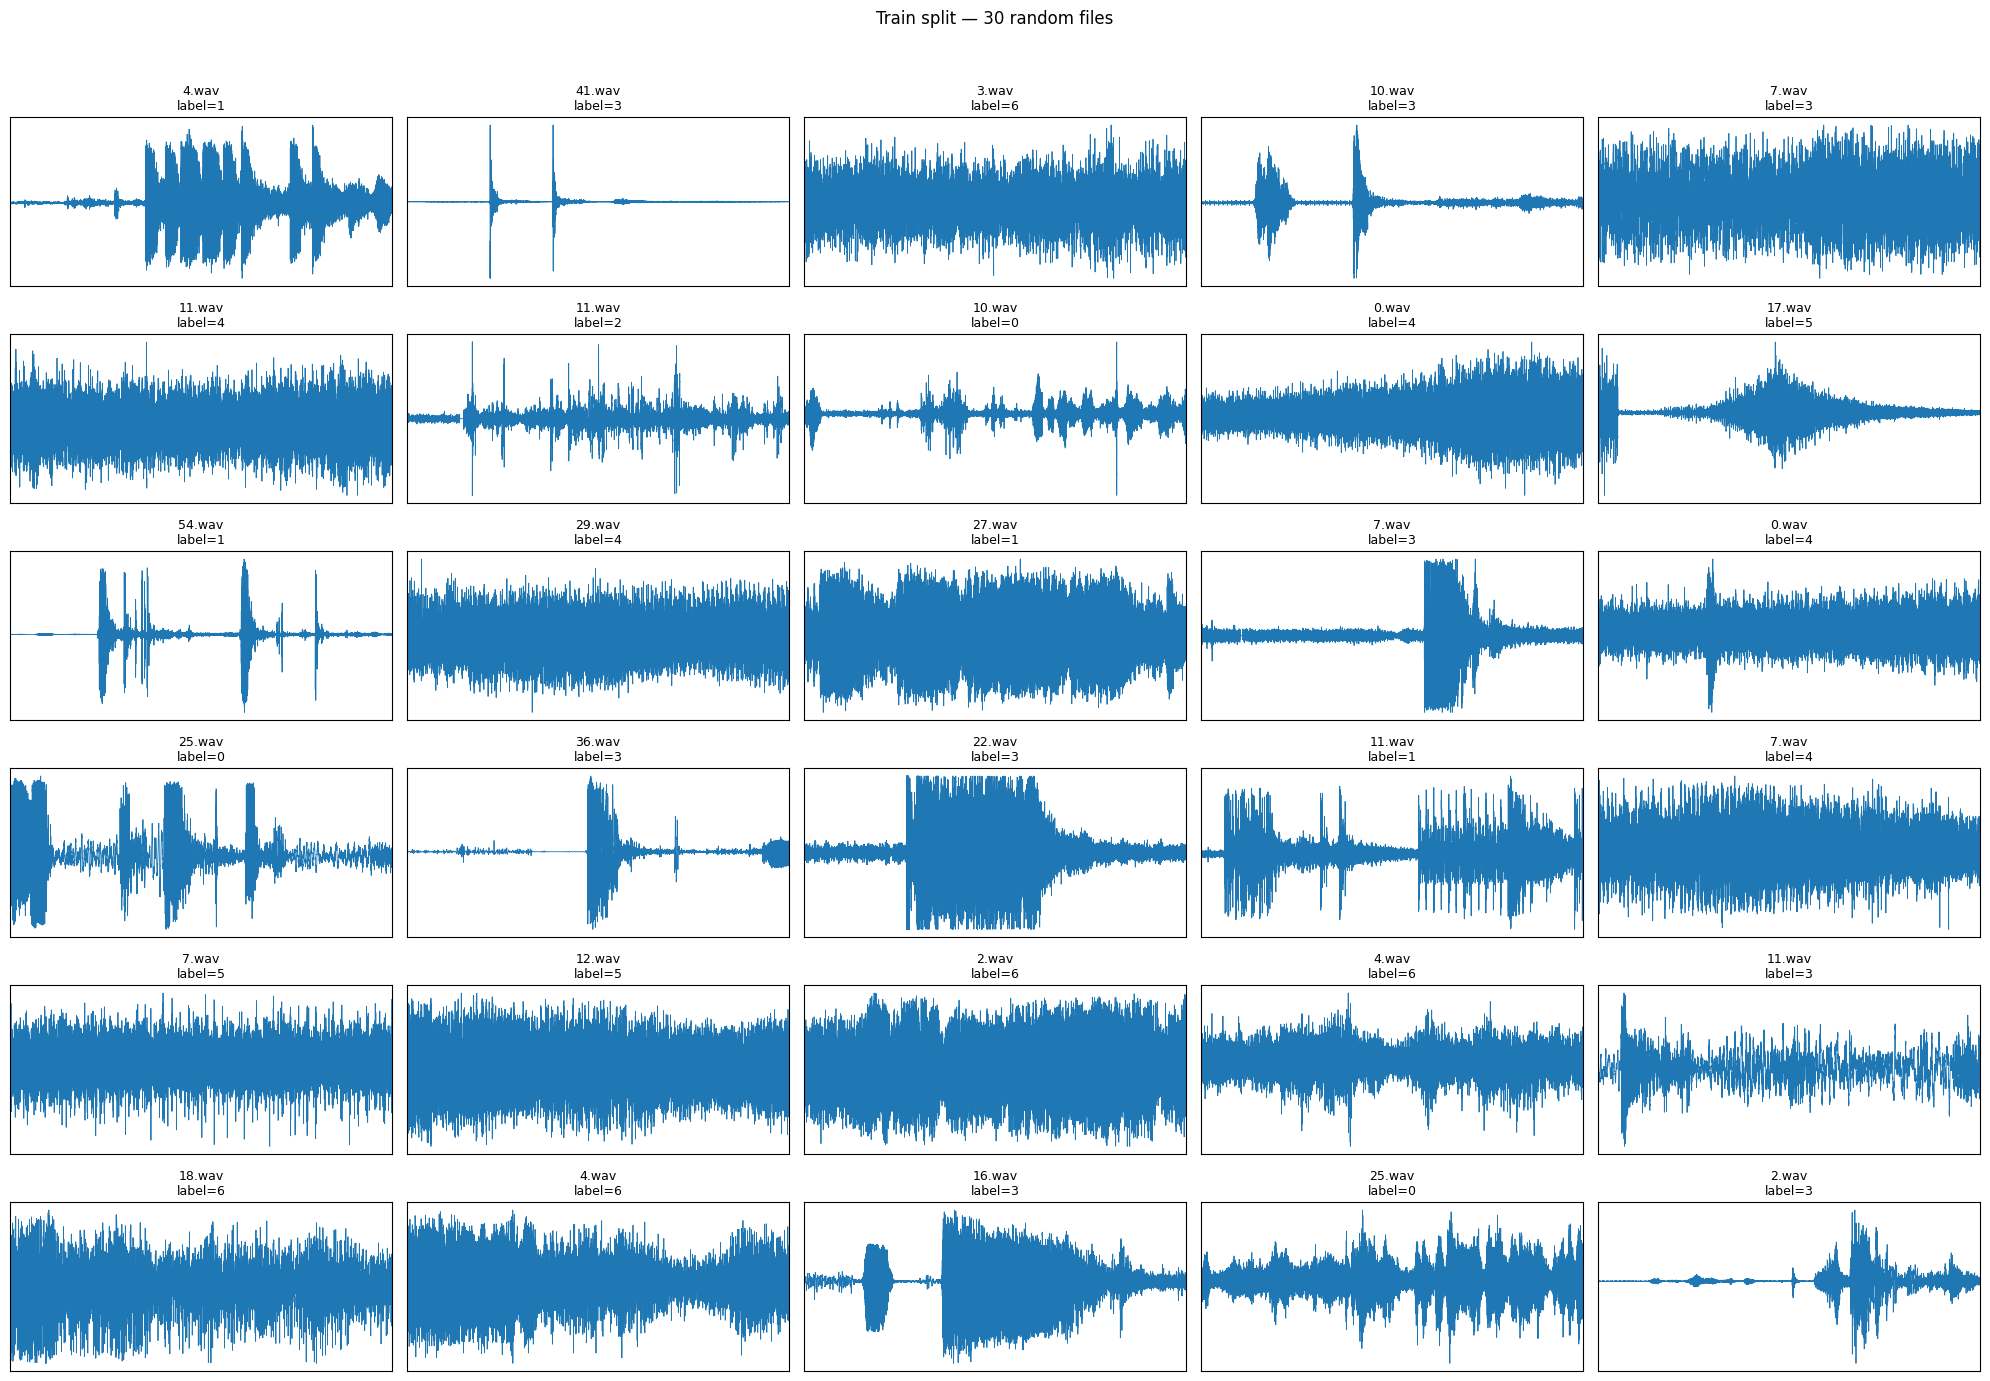

In [33]:
# === 4.3 Plot 30 random .wav files from a chosen split (waveform or mel-spectrogram) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, math, os
import librosa
try:
    import librosa.display  # optional, for nicer spectrogram axis labels
    HAS_DISPLAY = True
except Exception:
    HAS_DISPLAY = False

# ---------- Settings ----------
SPLIT = 'train'        # 'train' | 'val' | 'test'
N = 30                 # how many files to preview
RANDOM_SEED = None     # set to an int (e.g., 42) for reproducible picks
SHOW_SPECTRO = False   # set True to show mel-spectrograms instead of waveforms
MEL_BINS = 64          # only used if SHOW_SPECTRO=True
# -----------------------------

# Sanity: we rely on variables built earlier in the notebook
assert 'SR' in globals(), "SR not found. Run the Config cell."
assert 'train_df' in globals() and 'test_df' in globals(), "train_df/test_df not found. Run the CSV loading cells."
assert 'X_val' in globals() and 'y_val' in globals(), "Val split missing. Run the split cell."

# Build a "val_df" to ease selection
val_df = pd.DataFrame({'abs_path': X_val, 'label': y_val})

split_map = {
    'train': train_df[['abs_path','label']],
    'val'  : val_df[['abs_path','label']],
    'test' : test_df[['abs_path','label']],
}
assert SPLIT in split_map, f"Unknown SPLIT='{SPLIT}'. Use one of {list(split_map)}."
df = split_map[SPLIT].reset_index(drop=True)

n_total = len(df)
if n_total == 0:
    raise ValueError(f"No rows found in the {SPLIT} split.")

rng = np.random.default_rng(RANDOM_SEED)
idxs = rng.choice(n_total, size=min(N, n_total), replace=False)

cols = 5
rows = math.ceil(len(idxs) / cols)
plt.figure(figsize=(cols*4, rows*2.25))

for i, idx in enumerate(idxs):
    p = df['abs_path'].iloc[idx]
    lab = int(df['label'].iloc[idx])
    y, _ = librosa.load(p, sr=SR, mono=True)

    ax = plt.subplot(rows, cols, i+1)

    if SHOW_SPECTRO:
        # Mel-spectrogram thumbnail
        S = librosa.feature.melspectrogram(y=y, sr=SR, n_mels=MEL_BINS, hop_length=512, n_fft=1024, fmin=20)
        S_db = librosa.power_to_db(S, ref=np.max)
        if HAS_DISPLAY:
            librosa.display.specshow(S_db, sr=SR, hop_length=512, x_axis=None, y_axis=None, cmap='magma')
        else:
            ax.imshow(S_db, origin='lower', aspect='auto', cmap='magma')
    else:
        # Raw waveform
        ax.plot(y, lw=0.6, color='#1f77b4')
        ax.set_xlim(0, len(y))

    title_name = os.path.basename(p)
    ax.set_title(f"{title_name}\nlabel={lab}", fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])

plt.suptitle(f"{SPLIT.title()} split — {len(idxs)} random files", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

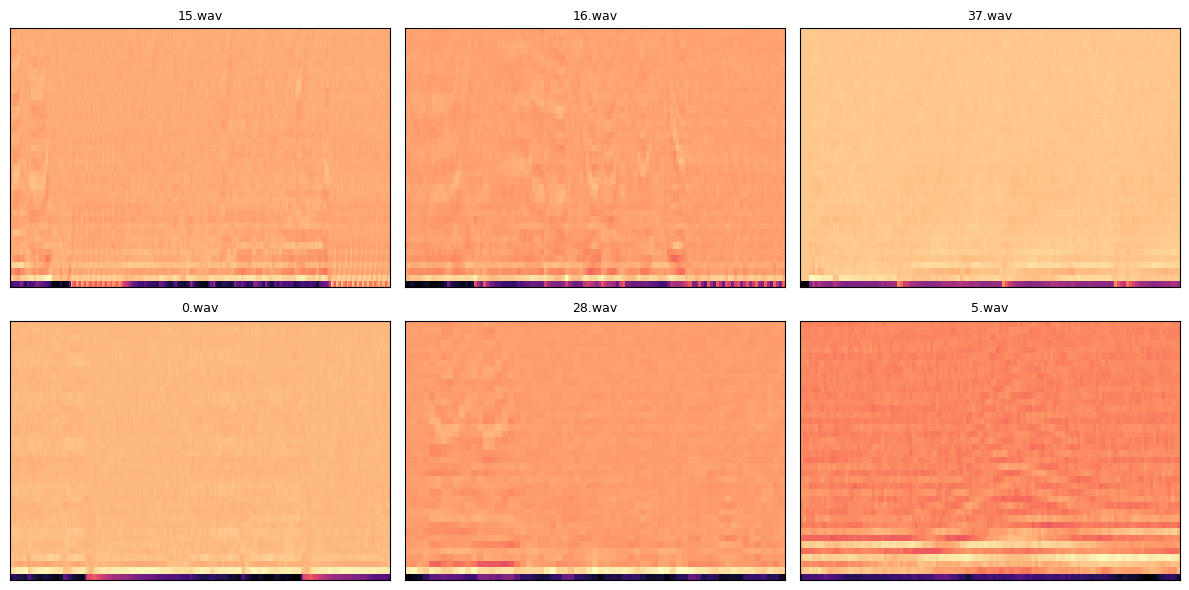

In [34]:
# === Optional: Plot MFCCs for a few random files (NOT the pipeline tensors) ===
import numpy as np, matplotlib.pyplot as plt, math, os, librosa
try:
    import librosa.display
    HAS_DISPLAY = True
except Exception:
    HAS_DISPLAY = False

SPLIT = 'train'
K = 6  # how many examples to show
idxs = np.random.choice(len(split_map[SPLIT]), size=min(K, len(split_map[SPLIT])), replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(idxs):
    p = split_map[SPLIT]['abs_path'].iloc[idx]
    y, _ = librosa.load(p, sr=SR, mono=True)
    mfcc = librosa.feature.mfcc(y=y, sr=SR, n_mfcc=40, n_fft=1024, hop_length=512, n_mels=64, fmin=20, fmax=None)
    ax = plt.subplot(2, math.ceil(K/2), i+1)
    if HAS_DISPLAY:
        librosa.display.specshow(mfcc, x_axis=None, y_axis=None, cmap='magma')
    else:
        ax.imshow(mfcc, origin='lower', aspect='auto', cmap='magma')
    ax.set_title(os.path.basename(p), fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout(); plt.show()


## 3) Load CSVs and split


In [35]:

import os
import pandas as pd

def _to_abs(p: str):
    return str(Path(BASE_DIR) / p.replace('/', os.sep))

train_df = pd.read_csv(TRAIN_CSV)[["path","label"]].dropna()
test_df  = pd.read_csv(TEST_CSV)[["path","label"]].dropna()
train_df["abs_path"] = train_df["path"].apply(_to_abs)
test_df["abs_path"]  = test_df["path"].apply(_to_abs)

missing_train = train_df[~train_df["abs_path"].apply(os.path.exists)]
missing_test  = test_df[~test_df["abs_path"].apply(os.path.exists)]
assert missing_train.empty and missing_test.empty, f"Missing files. Train miss={len(missing_train)}, Test miss={len(missing_test)}"

all_labels = np.sort(pd.unique(pd.concat([train_df["label"], test_df["label"]]).astype(int)))
num_classes = int(all_labels.max()) + 1
class_names = [f"class_{i}" for i in range(num_classes)]

from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(
    train_df["abs_path"].values,
    train_df["label"].values.astype(int),
    test_size=VAL_RATIO, random_state=SEED, stratify=train_df["label"].values
)
X_te = test_df["abs_path"].values
y_te = test_df["label"].values.astype(int)

len(X_tr), len(X_val), len(X_te), num_classes, class_names[:5]


(5786, 643, 1037, 7, ['class_0', 'class_1', 'class_2', 'class_3', 'class_4'])


## 4) Features: MFCC(+Δ,+ΔΔ) + SpecAugment


In [36]:

import librosa, numpy as np, tensorflow as tf

def _load_fixed(path, training=False):
    y, _ = librosa.load(path, sr=SR, mono=True)
    if len(y) < TARGET_SAMPLES:
        y = np.pad(y, (0, TARGET_SAMPLES - len(y)), mode="reflect")
    elif len(y) > TARGET_SAMPLES:
        start = np.random.randint(0, len(y) - TARGET_SAMPLES + 1) if training else (len(y)-TARGET_SAMPLES)//2
        y = y[start:start+TARGET_SAMPLES]
    return y

def _specaugment(mfcc):
    n_mfcc, T = mfcc.shape
    for _ in range(FREQ_MASKS):
        f = int(np.round(FREQ_MASK_PCT * n_mfcc)); f0 = np.random.randint(0, max(1, n_mfcc - f))
        mfcc[f0:f0+f, :] = 0
    for _ in range(TIME_MASKS):
        t = int(np.round(TIME_MASK_PCT * T)); t0 = np.random.randint(0, max(1, T - t))
        mfcc[:, t0:t0+t] = 0
    return mfcc

def _compute_mfcc_np(path_bytes, training=False):
    path = path_bytes.decode("utf-8")
    y = _load_fixed(path, training=training)
    base = librosa.feature.mfcc(y=y, sr=SR, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP,
                                n_mels=N_MELS, fmin=FMIN, fmax=FMAX)
    base = (base - np.mean(base, axis=1, keepdims=True)) / (np.std(base, axis=1, keepdims=True)+1e-8)
    if base.shape[1] < TIME_STEPS:
        base = np.pad(base, ((0,0),(0,TIME_STEPS-base.shape[1])), mode="constant")
    elif base.shape[1] > TIME_STEPS:
        s = np.random.randint(0, base.shape[1]-TIME_STEPS+1) if training else (base.shape[1]-TIME_STEPS)//2
        base = base[:, s:s+TIME_STEPS]
    if USE_DELTAS:
        d = librosa.feature.delta(base); d2 = librosa.feature.delta(base, order=2)
        feat = np.stack([base, d, d2], axis=-1)
    else:
        feat = base[..., np.newaxis]
    if SPEC_AUG and training:
        if USE_DELTAS:
            base_aug = _specaugment(feat[...,0].copy())
            d = librosa.feature.delta(base_aug); d2 = librosa.feature.delta(base_aug, order=2)
            feat = np.stack([base_aug, d, d2], axis=-1)
        else:
            feat[...,0] = _specaugment(feat[...,0])
    dtype = np.float16 if MIXED_PRECISION else np.float32
    return feat.astype(dtype)

def _tf_mfcc(path, label, training):
    x = tf.numpy_function(lambda p: _compute_mfcc_np(p, training=training), [path], tf.float16 if MIXED_PRECISION else tf.float32)
    x.set_shape(INPUT_SHAPE)
    return x, label

def make_ds(paths, labels, training=False, batch=BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices((paths.astype("S"), labels))
    if training:
        ds = ds.shuffle(4096, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(lambda p,y: _tf_mfcc(p,y,training), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(X_tr, y_tr, training=True)
val_ds   = make_ds(X_val, y_val, training=False)
test_ds  = make_ds(X_te, y_te, training=False)



## 5) Model (2D‑CNN) + live curves callback


In [37]:

from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

class LivePlot(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.history = {"accuracy":[], "val_accuracy":[], "loss":[], "val_loss":[]}
    def on_epoch_end(self, epoch, logs=None):
        for k in list(self.history.keys()):
            if k in logs: self.history[k].append(logs[k])
        clear_output(wait=True)
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.plot(self.history['accuracy']); plt.plot(self.history['val_accuracy'])
        plt.legend(['train_acc','val_acc']); plt.grid(True)
        plt.subplot(1,2,2)
        plt.plot(self.history['loss']); plt.plot(self.history['val_loss'])
        plt.legend(['train_loss','val_loss']); plt.grid(True)
        plt.tight_layout(); display(plt.gcf()); plt.close()

def build_cnn(input_shape=INPUT_SHAPE, n_classes=num_classes):
    inp = keras.Input(shape=input_shape)
    x = layers.Conv2D(48, (3,3), padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(96, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.30)(x)

    x = layers.Conv2D(192, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.30)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(160, activation='relu')(x)
    x = layers.Dropout(0.35)(x)

    out_dtype = 'float32' if MIXED_PRECISION else None
    out = layers.Dense(n_classes, activation='softmax', dtype=out_dtype)(x)
    return keras.Model(inp, out)

with strategy.scope():
    model = build_cnn()
    opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary(line_length=120)


Model: "model_2"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 input_3 (InputLayer)                                 [(None, 40, 92, 3)]                             0                 
                                                                                                                        
 conv2d_6 (Conv2D)                                    (None, 40, 92, 48)                              1344              
                                                                                                                        
 batch_normalization_6 (BatchNormalization)           (None, 40, 92, 48)                              192               
                                                                                                                        
 max_pooling2d_


## 6) Train


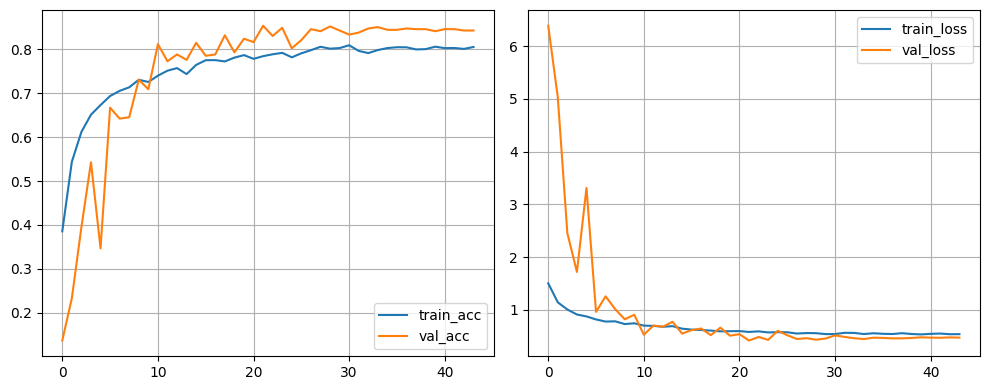

181/181 [==============================] - 63s 348ms/step - loss: 0.5367 - accuracy: 0.8054 - val_loss: 0.4706 - val_accuracy: 0.8429 - lr: 1.9531e-06
Epoch 45/150
134/181 [=====================>........] - ETA: 14s - loss: 0.5484 - accuracy: 0.8015

KeyboardInterrupt: 

In [38]:

from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path

classes = np.arange(num_classes)
cw_arr = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
class_weights = {int(c): float(w) for c, w in zip(classes, cw_arr)}
print('Class weights:', class_weights)

cbs = [
    keras.callbacks.ModelCheckpoint(str(Path(CKPT_DIR)/'best.keras'), monitor='val_accuracy', mode='max', save_best_only=True),
    
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    LivePlot()
]

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, class_weight=class_weights, callbacks=cbs, verbose=1)

import pandas as pd
model_path = str(Path(OUT_DIR)/'mad_cnn_mfcc_model.keras')
model.save(model_path)
pd.DataFrame(history.history).to_csv(Path(ANALYSIS_DIR)/'history.csv', index=False)
print('Saved:', model_path)



## 7) Evaluate + confusion matrix



TEST — accuracy: 0.8419 | loss: 0.7781

Classification report:
               precision    recall  f1-score   support

     class_0     0.9316    0.8551    0.8917       207
     class_1     0.9677    0.7500    0.8451       280
     class_2     0.8679    0.8846    0.8762       104
     class_3     0.6594    0.8750    0.7521       104
     class_4     0.7124    0.8934    0.7927       122
     class_5     0.8022    0.8022    0.8022        91
     class_6     0.8521    0.9380    0.8930       129

    accuracy                         0.8419      1037
   macro avg     0.8276    0.8569    0.8361      1037
weighted avg     0.8606    0.8419    0.8442      1037



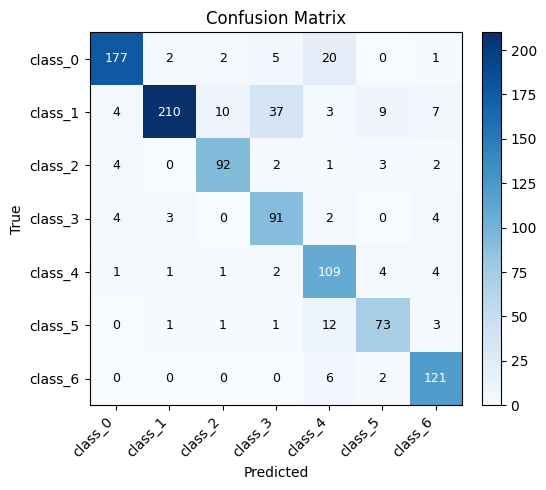

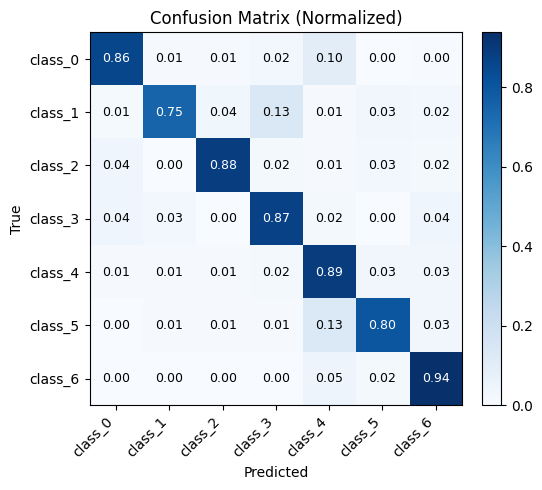

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt, itertools
from pathlib import Path

te_loss, te_acc = model.evaluate(test_ds, verbose=0)
print(f"""
TEST — accuracy: {te_acc:.4f} | loss: {te_loss:.4f}""")

y_true, y_pred = [], []
for xb, yb in test_ds:
    probs = model.predict(xb, verbose=0)
    y_true.extend(yb.numpy().tolist())
    y_pred.extend(np.argmax(probs, axis=1).tolist())

# This line is corrected to fix the syntax error
print('\nClassification report:\n', classification_report(y_true, y_pred, target_names=class_names, digits=4))
cm = confusion_matrix(y_true, y_pred)


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', out_png=None):
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-8)
    plt.figure(figsize=(6,5))
    im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45, ha='right'); plt.yticks(ticks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() + cm.min()) / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color=('white' if cm[i, j] > thresh else 'black'), fontsize=9)
    plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout()
    if out_png: plt.savefig(out_png, dpi=150)
    plt.show(); plt.close()

plot_confusion_matrix(cm, class_names, False, 'Confusion Matrix', Path(ANALYSIS_DIR)/'confusion_matrix.png')
plot_confusion_matrix(cm, class_names, True,  'Confusion Matrix (Normalized)', Path(ANALYSIS_DIR)/'confusion_matrix_norm.png')


## 8) Inference helper (single file, multi‑crop)


In [50]:
# === Inference helper (auto-shape from model, robust for CNN/CRNN) ===
from pathlib import Path
import json, os
import numpy as np
import librosa
import tensorflow as tf

# ---------- 1) Locate model + config ----------
BASE_DIR_PATH = Path(BASE_DIR)
MODELS_DIR = BASE_DIR_PATH / "models"

# Prefer CRNN if available
CANDIDATE_MODELS = [
    MODELS_DIR / "mad_crnn_mfcc_model.keras",
    MODELS_DIR / "mad_cnn_mfcc_model.keras",
    MODELS_DIR / "mad_cnn_mfcc_model.h5",  # optional legacy
]

MODEL_PATH = None
for cand in CANDIDATE_MODELS:
    if cand.exists():
        MODEL_PATH = cand
        break

if MODEL_PATH is None:
    raise FileNotFoundError(
        f"No model found in {MODELS_DIR}. Expected one of: "
        + ", ".join(str(p) for p in CANDIDATE_MODELS)
    )

CONFIG_PATH = MODELS_DIR / "config.json"
if CONFIG_PATH.exists():
    with open(CONFIG_PATH, "r") as f:
        C = json.load(f)
else:
    # Fall back to notebook variables
    print("WARN: config.json not found — falling back to notebook variables.")
    C = dict(SR=SR, DURATION=DURATION, N_MFCC=N_MFCC, N_MELS=N_MELS, N_FFT=N_FFT, HOP=HOP,
             FMIN=FMIN, FMAX=FMAX, USE_DELTAS=USE_DELTAS, TIME_STEPS=TIME_STEPS, N_CH=N_CH)

LABELS_PATH = MODELS_DIR / "label_map.json"
CLASS_NAMES = None
if LABELS_PATH.exists():
    try:
        with open(LABELS_PATH, "r", encoding="utf-8") as f:
            lm = json.load(f)
        if isinstance(lm, dict) and "class_names" in lm and isinstance(lm["class_names"], list):
            CLASS_NAMES = lm["class_names"]
    except Exception as e:
        print("WARN: Could not parse label_map.json:", e)

# ---------- 2) Load model & OVERRIDE shapes from model.input_shape ----------
model = tf.keras.models.load_model(str(MODEL_PATH))
print(f"Loaded model: {MODEL_PATH.name}")

# The model is built with input=(None, n_mfcc, time_steps, channels)
try:
    in_shape = model.input_shape  # e.g., (None, 40, 124, 3)
    N_MFCC_model, TIME_STEPS_model, N_CH_model = int(in_shape[1]), int(in_shape[2]), int(in_shape[3])
except Exception as e:
    raise RuntimeError(f"Could not read model.input_shape: {e}")

# Use the model's own shape to override config-dependent values
SR          = C.get("SR", 16000)
DURATION    = C.get("DURATION", 3.0)  # only affects crop spacing; final feature time is forced to TIME_STEPS_model
N_MELS      = C.get("N_MELS", 64)
N_FFT       = C.get("N_FFT", 1024)
HOP         = C.get("HOP", 512)
FMIN        = C.get("FMIN", 20)
FMAX        = C.get("FMAX", None)

# Critical overrides to avoid mismatch:
N_MFCC      = N_MFCC_model
TIME_STEPS  = TIME_STEPS_model
N_CH        = N_CH_model
USE_DELTAS  = (N_CH == 3)

TARGET_SAMPLES = int(SR * DURATION)

# Optional: sanity print
print(f"Inference config → SR={SR}, DURATION={DURATION}, N_MFCC={N_MFCC}, TIME_STEPS={TIME_STEPS}, N_CH={N_CH}, USE_DELTAS={USE_DELTAS}")

# If label map missing, derive class names from model output width
if CLASS_NAMES is None:
    try:
        num_classes = model.output_shape[-1]
        CLASS_NAMES = [f"class_{i}" for i in range(num_classes)]
    except Exception:
        CLASS_NAMES = None

# ---------- 3) Preprocessing (must produce (N_MFCC, TIME_STEPS, N_CH)) ----------
def _fix_length(y: np.ndarray) -> np.ndarray:
    if len(y) < TARGET_SAMPLES:
        return np.pad(y, (0, TARGET_SAMPLES - len(y)), mode="reflect")
    elif len(y) > TARGET_SAMPLES:
        s = (len(y) - TARGET_SAMPLES) // 2  # center crop at inference
        return y[s:s+TARGET_SAMPLES]
    return y

def _mfcc_from_y(y: np.ndarray) -> np.ndarray:
    base = librosa.feature.mfcc(
        y=y, sr=SR, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP,
        n_mels=N_MELS, fmin=FMIN, fmax=FMAX
    )  # (n_mfcc, T)
    base = (base - np.mean(base, axis=1, keepdims=True)) / (np.std(base, axis=1, keepdims=True) + 1e-8)

    # Force time dimension to TIME_STEPS expected by the model
    if base.shape[1] < TIME_STEPS:
        base = np.pad(base, ((0,0),(0, TIME_STEPS - base.shape[1])), mode="constant")
    elif base.shape[1] > TIME_STEPS:
        s2 = (base.shape[1] - TIME_STEPS) // 2
        base = base[:, s2:s2+TIME_STEPS]

    if USE_DELTAS:
        d  = librosa.feature.delta(base)
        d2 = librosa.feature.delta(base, order=2)
        feat = np.stack([base, d, d2], axis=-1)  # (n_mfcc, TIME_STEPS, 3)
    else:
        feat = base[..., np.newaxis]             # (n_mfcc, TIME_STEPS, 1)
    return feat.astype(np.float32)

def _make_crops(y: np.ndarray, multi_crop: int) -> np.ndarray:
    y = np.array(y, dtype=np.float32)
    if len(y) < TARGET_SAMPLES:
        y = _fix_length(y)
        crops = [y]
    else:
        if multi_crop <= 1:
            crops = [_fix_length(y)]
        else:
            span = max(0, len(y) - TARGET_SAMPLES)
            offsets = np.linspace(0, span, num=multi_crop, dtype=int)
            crops = [ y[s:s+TARGET_SAMPLES] for s in offsets ]
    xs = [ _mfcc_from_y(c) for c in crops ]
    X = np.stack(xs, axis=0)  # (N, N_MFCC, TIME_STEPS, N_CH)
    # Final sanity check:
    assert X.shape[1:] == (N_MFCC, TIME_STEPS, N_CH), f"Built X with shape {X.shape}, expected (N, {N_MFCC}, {TIME_STEPS}, {N_CH})"
    return X

# ---------- 4) Public API ----------
def predict_file(wav_path: str, top_k: int = 3, multi_crop: int = 5, return_probs: bool = False):
    y, _ = librosa.load(wav_path, sr=SR, mono=True)
    X = _make_crops(y, multi_crop=multi_crop)
    probs = model.predict(X, verbose=0).mean(axis=0)  # (num_classes,)
    top_idx = np.argsort(probs)[::-1][:top_k]
    if CLASS_NAMES is not None and len(CLASS_NAMES) == probs.shape[-1]:
        top = [(CLASS_NAMES[i], float(probs[i])) for i in top_idx]
    else:
        top = [(int(i), float(probs[i])) for i in top_idx]
    return (top, probs) if return_probs else top

def predict_many(paths, multi_crop: int = 5, top_k: int = 3):
    results = []
    for p in paths:
        top, probs = predict_file(p, top_k=top_k, multi_crop=multi_crop, return_probs=True)
        pred_idx = int(np.argmax(probs))
        pred_label = CLASS_NAMES[pred_idx] if CLASS_NAMES else pred_idx
        results.append({
            "path": str(p),
            "top": top,
            "pred": pred_label,
            "conf": float(probs[pred_idx]),
        })
    return results

def pretty_print_prediction(wav_path: str, top_k: int = 5, multi_crop: int = 5):
    top = predict_file(wav_path, top_k=top_k, multi_crop=multi_crop, return_probs=False)
    print(f"\nFile: {wav_path}")
    for rank, (lab, pr) in enumerate(top, 1):
        print(f"  {rank}. {lab:<12}  {pr:.4f}")

# ---------- 5) Example ----------
pretty_print_prediction(r"C:\Users\Moham\Desktop\syrine\archive\MAD_dataset\test\077\4.wav", top_k=5, multi_crop=7)

Loaded model: mad_crnn_mfcc_model.keras
Inference config → SR=16000, DURATION=3.0, N_MFCC=40, TIME_STEPS=124, N_CH=3, USE_DELTAS=True

File: C:\Users\Moham\Desktop\syrine\archive\MAD_dataset\test\077\4.wav
  1. class_1       0.9997
  2. class_3       0.0001
  3. class_5       0.0001
  4. class_4       0.0001
  5. class_2       0.0000
